# Pseudotime using spectral embedding

In [1]:
%matplotlib inline
import numpy as np
import math
import os
from numpy.matlib import repmat
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy import optimize
from OscopeBootstrap.pseudotime import estimate_pseudotime_using_spectral_embedding, calculate_metrics, \
    plot_latent_space, plot_latent_space_notrue, plot_gene_fits, plot_gene_fits_notrue, plot_correspondence_of_peaktime_and_times

## Define a test sin function for the fitting

In [2]:
#def testsin(x,a,b):
#    return a*np.sin(b*x)

#def testsin_phase(x,a,b,p):
#    return a*np.sin(p + b*x)
def testsin_phase(x, dist, a,b,p):
    return dist + a * np.sin(p + b*x)

## Load data

In [3]:
case='3groups'
path_to_data = '../Glioblastoma_project/Simulations/'
path_to_comm = '../Glioblastoma_project/Results_Sim/'
fig_root='../Glioblastoma_project/Plots/'
path_to_fig=f'{fig_root}{case}/'
datafile=f'{path_to_data}{case}Data.csv'
data=pd.read_csv(datafile,header=0, index_col=0)
if not os.path.exists(path_to_fig):
    os.makedirs(path_to_fig)


In [4]:
data

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C990,C991,C992,C993,C994,C995,C996,C997,C998,C999
G1SO0,0.564807,0.605190,0.585519,0.511111,0.590691,0.558765,0.517371,0.527141,0.476124,0.468268,...,0.777169,0.743082,0.569569,0.656653,0.654306,0.633879,0.628523,0.645037,0.627872,0.574586
G1SO1,0.594290,0.638473,0.577606,0.684247,0.576496,0.590913,0.523560,0.516269,0.532766,0.478105,...,0.753473,0.653294,0.635208,0.570100,0.649579,0.591142,0.606206,0.669833,0.603698,0.619117
G1SO2,0.653648,0.630442,0.623695,0.635863,0.550437,0.473477,0.654859,0.538542,0.484720,0.517986,...,0.721603,0.731018,0.651663,0.727595,0.661038,0.683763,0.541807,0.664304,0.621853,0.615759
G1SO3,0.653790,0.585453,0.674399,0.588559,0.511714,0.480979,0.597823,0.559353,0.563225,0.465578,...,0.712348,0.662593,0.739529,0.683775,0.710172,0.669115,0.628947,0.748187,0.684971,0.571591
G1SO4,0.618357,0.634566,0.560158,0.499473,0.651043,0.601003,0.505850,0.558589,0.577694,0.499358,...,0.635150,0.634417,0.593716,0.653883,0.757748,0.566642,0.625798,0.497763,0.638704,0.636742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R95,0.425430,-0.692004,-0.133809,1.131533,-0.732209,-0.767441,1.050120,-2.756751,1.067599,0.793788,...,1.580477,-1.087177,0.694951,-0.331909,0.708701,1.777161,0.109668,-1.301194,0.659192,-1.395693
R96,0.358677,-0.423335,-1.928716,0.846826,-2.905250,-0.931216,0.168015,1.742882,0.073547,-0.995624,...,0.863003,0.358672,0.067383,0.315439,-0.678946,-0.375205,-1.533672,-0.482139,-1.262190,1.058803
R97,-0.596144,-0.069893,-0.297207,2.093688,1.264553,0.161750,-0.943055,-1.923060,0.690404,-1.293365,...,1.689941,-1.103384,-2.059792,-0.735657,-0.449209,-1.888586,-0.340834,-0.064311,1.062931,-1.502927
R98,-0.000781,-0.587796,-1.009289,1.716721,-0.446126,0.532085,0.496604,0.744484,1.528615,-0.300105,...,0.074806,-0.388593,-0.186430,0.424912,1.448867,-1.162169,0.008858,-0.772336,-1.407813,-0.507658


## load community info

In [5]:
commDataFile=f'{path_to_comm}{case}Comm.csv'
commReportFile=f'{path_to_comm}Report{case}.csv'
commData = pd.read_csv(commDataFile,header=0, index_col=1)
commData=commData[['CommunityID']]
genelist=commData.index.values
ncomm=commData.max()
commInfo=pd.read_csv(commReportFile,header=0, index_col=1)
print(commReportFile)

../Glioblastoma_project/Results_Sim/Report3groups.csv


In [6]:
commInfo=commInfo.sort_index()


In [7]:
#commInfo

In [8]:
communities=commInfo.index.values
currentCFlag=commInfo.loc[communities==1,'LinFlag']
print(currentCFlag.values)
#selecting  linear clusters:

Linear=commInfo[commInfo.LinFlag==1]
LinearId=Linear.index.values
#selecting  non linear clusters:
print('Linear Communities')
print(LinearId)
NonLinear=commInfo[commInfo.LinFlag==0]
NonLinearId=NonLinear.index.values
print('Non Linear Communities')
print(NonLinearId)

[0]
Linear Communities
[2 3 4]
Non Linear Communities
[1 5 6 7 8 9]


# Get data for the community of interest - Linear Case

LINEAR COMMUNITIES PLOT
Community=
2
(20, 1000)
Spectral pseudotime time
Gene plots
[ 0.9337633   6.33890074 -1.61116049]
[ 0.94057428  6.33042115 -1.6060199 ]
[ 0.94015251  6.32929774 -1.60735629]
[ 0.93300605  6.34444645 -1.61038601]
[ 0.93335146  6.33171565 -1.61104043]
[ 0.93130962  6.33533476 -1.60892037]
[ 0.93844394  6.33357017 -1.61007932]
[ 0.93376245  6.34123089 -1.61224418]
[ 0.93736589  6.34682695 -1.61313367]
[ 0.93746532  6.32455008 -1.60461406]
[ 0.93590036  6.36588085 -1.62195118]
[ 0.92910618  6.33297276 -1.61122778]
[ 0.93441446  6.33131554 -1.6114721 ]
[ 0.94000819  6.31712653 -1.60386639]
[ 0.94334906  6.29411971 -1.58697291]
[ 0.93802869  6.32941609 -1.60742453]
[ 0.92536469  6.33792838 -1.61702262]
[ 0.94756982  6.30242402 -1.59574778]
[ 0.93319559  6.32653681 -1.60575025]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.93573669  6.33036281 -1.6031932 ]
Community=
3
(10, 1000)
Spectral pseudotime time


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Gene plots
[ 0.92106617  6.3871637  -1.61877391]
[ 0.9150462   6.3966359  -1.62587118]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.91471864  6.40877636 -1.63457987]
[ 0.92219036  6.41463613 -1.63836715]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.92113192  6.34863376 -1.59782811]
[ 0.92080809  6.35542336 -1.6110777 ]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.9317548   6.3379377  -1.60769554]
[ 0.913009    6.37989536 -1.61972893]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.92975502  6.34942941 -1.60349238]
[ 0.92152413  6.38248709 -1.62319662]
Community=
4
(10, 1000)
Spectral pseudotime time


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Gene plots
[ 0.93413908  6.39624284 -1.62911372]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.93197258  6.39543789 -1.62514128]
[ 0.93401762  6.39345709 -1.62809124]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.93311093  6.39587306 -1.62619484]
[ 0.93208398  6.39480173 -1.62799951]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.93126974  6.39367539 -1.62768345]
[ 0.93109262  6.38423905 -1.62140978]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()
<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.93304511  6.40311041 -1.63910127]
[ 0.93688217  6.3883168  -1.62909466]


<ipython-input-9-25d394463a69>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 0.93063337  6.38675406 -1.62631045]


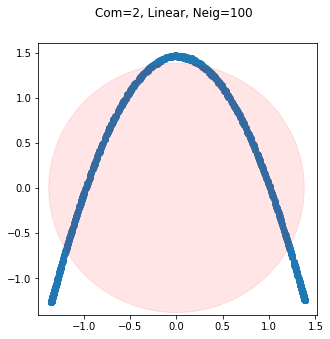

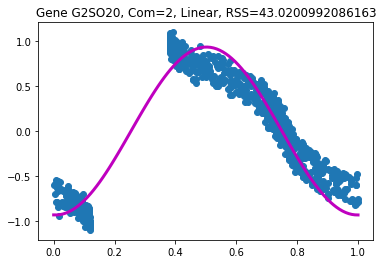

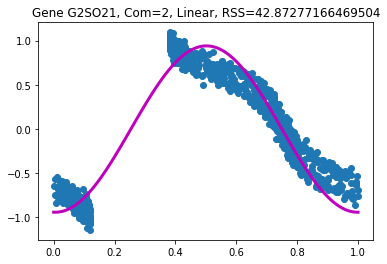

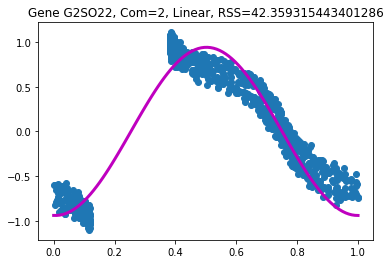

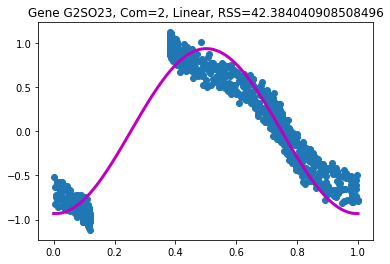

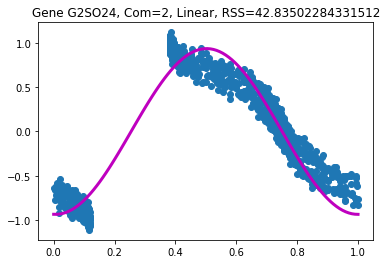

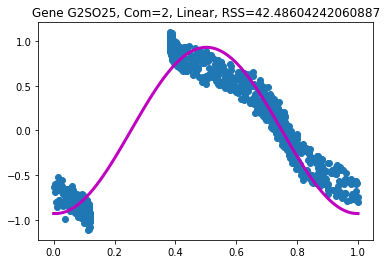

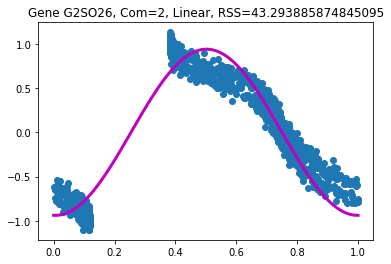

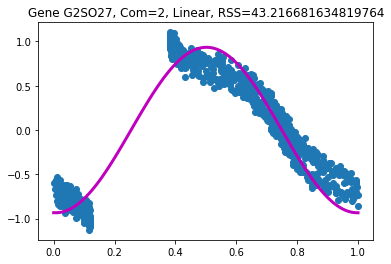

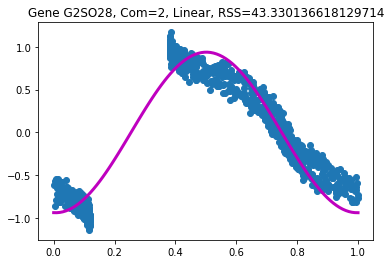

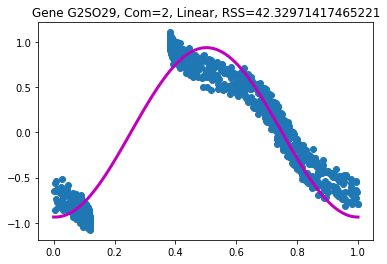

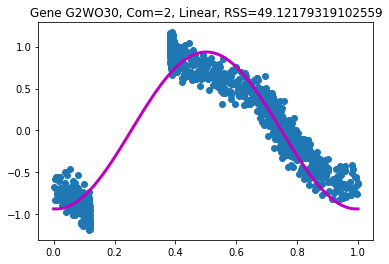

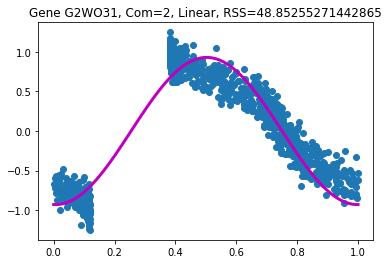

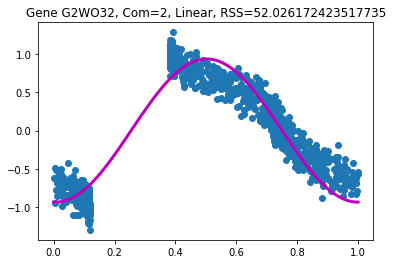

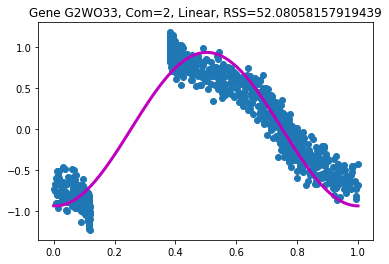

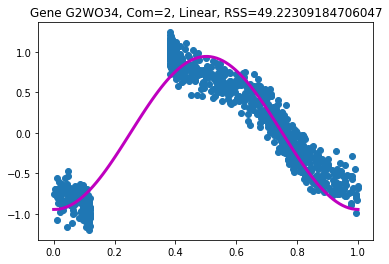

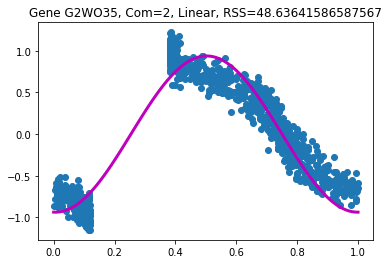

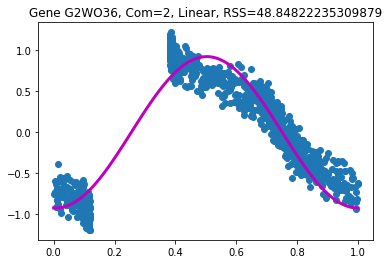

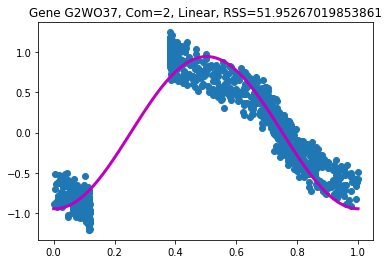

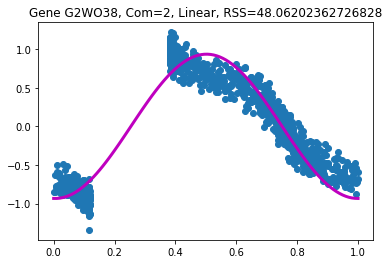

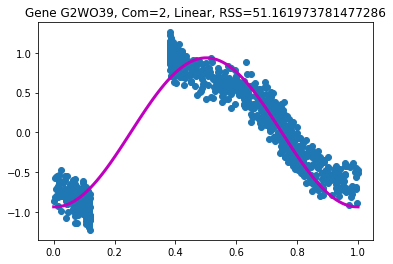

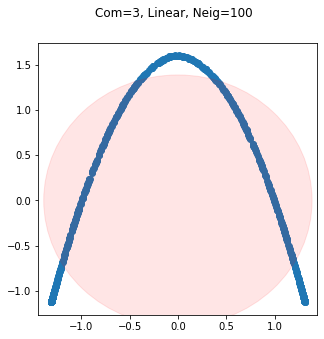

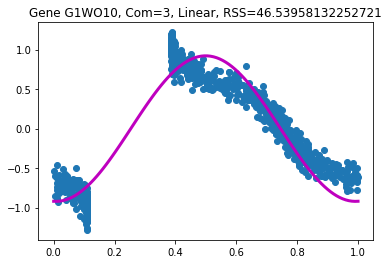

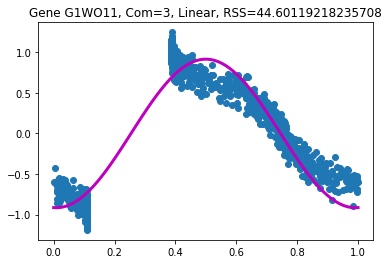

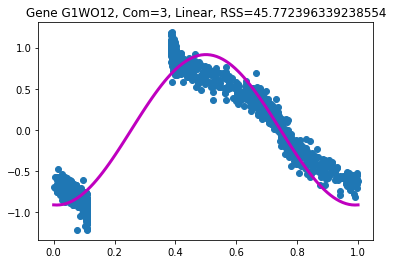

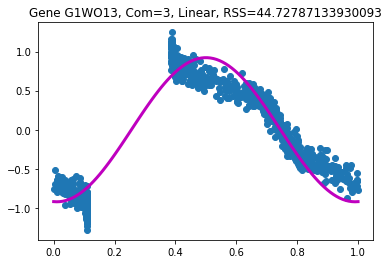

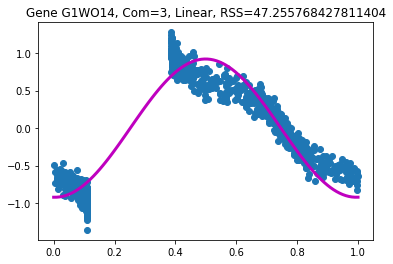

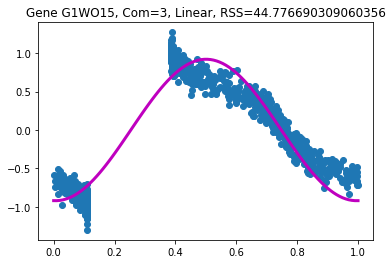

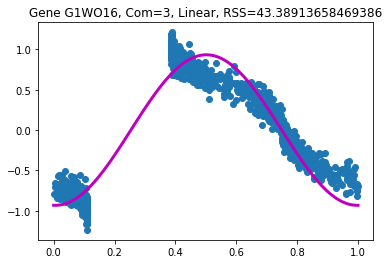

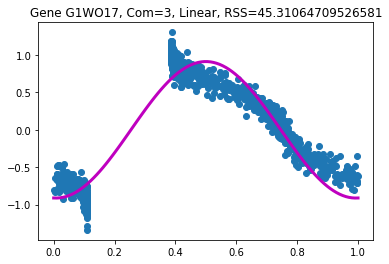

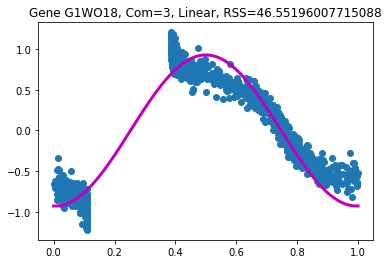

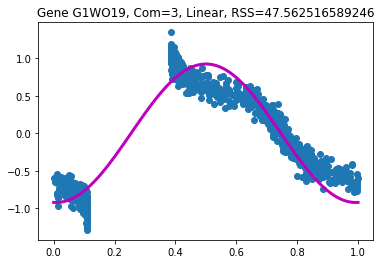

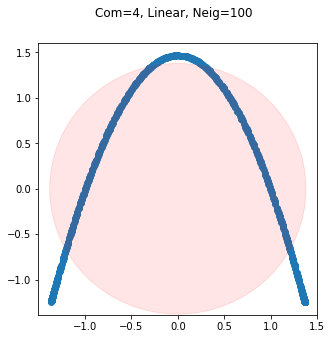

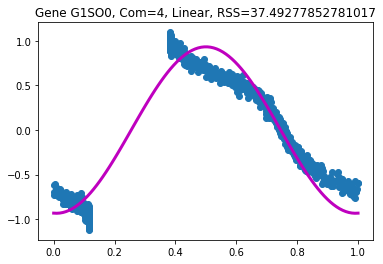

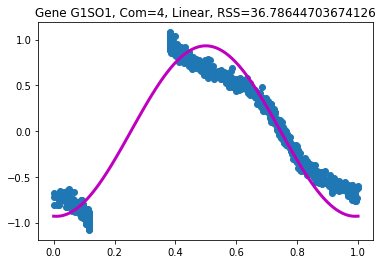

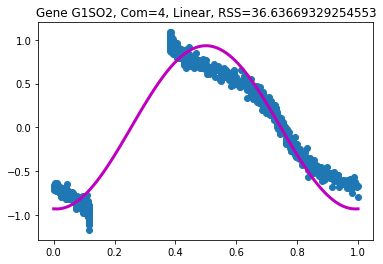

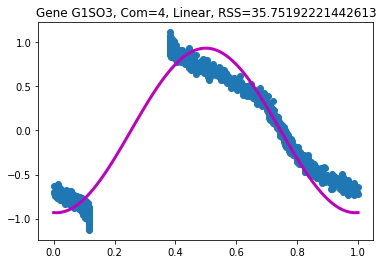

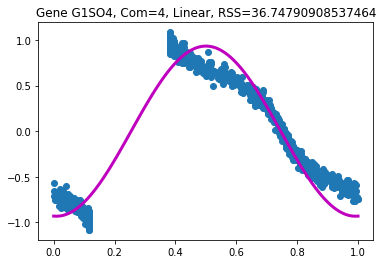

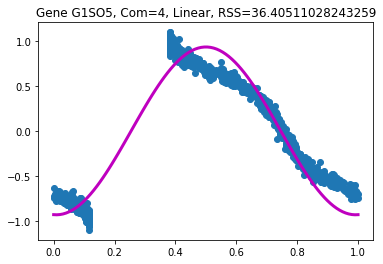

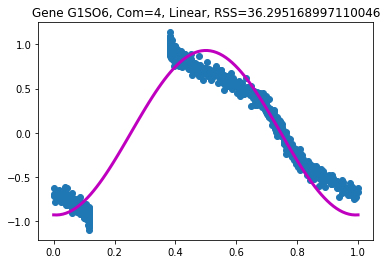

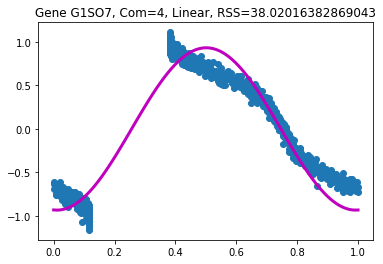

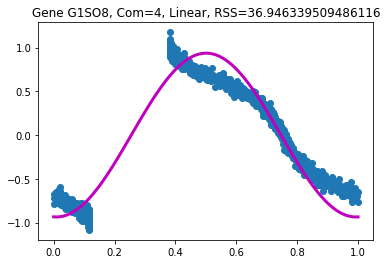

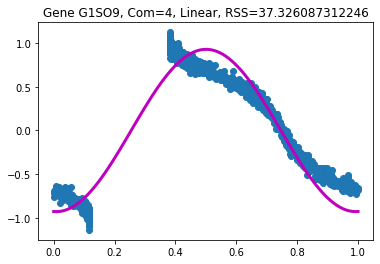

In [9]:
#Start from the linear communities
print('LINEAR COMMUNITIES PLOT')
for commId in LinearId:
    print('Community=')
    print(commId)
    #commId=LinearId[4]
    Flag="Linear"
    comm = commData[commData.CommunityID == commId]
    #select ONLY the genes in the selected community to use laterin the plot
    genelist=comm.index.values
    training_data=data.loc[comm.index] 
    nsamp=training_data.shape[1]
    print(training_data.shape)

    n_neighbors=math.ceil(nsamp/10)
    n_neighbors
    print('Spectral pseudotime time')
    pt_spectral, latent_space_2d = estimate_pseudotime_using_spectral_embedding(training_data.T, n_neighbors)
    [fig, ax] = plot_latent_space_notrue(latent_space_2d)
    PseudoTimefile=f'{path_to_fig}LinearPseudotime{case}_comm_{commId}.pdf'

    pt = PdfPages(PseudoTimefile)
    fig.suptitle("Com="+str(commId) + ", "+ Flag + ', Neig=' +str(n_neighbors))
    fig
    pt.savefig(fig)

    pt.close()
    print('Gene plots')
    geneplot=genelist 
    idx=np.argsort(pt_spectral)
    figfile=f'{path_to_fig}PlotfilterSin{case}_comm_{commId}.pdf'
    pp = PdfPages(figfile)
    for g in geneplot:
        f=plt.figure()
        gene_series = data.loc[g][idx]
        params,params_covariance=optimize.curve_fit(testsin_phase,pt_spectral[idx],gene_series,p0=[2,2,0])
        #fspline = UnivariateSpline(pt_spectral[idx], gene_series, check_finite=True)
        print(params)
        xtest = np.linspace(np.min(pt_spectral), np.max(pt_spectral), 100)
        #fs = fspline(xtest)
        ts=testsin_phase(xtest,params[0],params[1],params[2])
        #plt spline
        residuals=gene_series-testsin_phase(pt_spectral[idx],params[0],params[1],params[2])
        rss=sum(residuals**2)
        
        plt.plot(xtest, ts, color='m', lw=3);
        #plot data
        plt.scatter(pt_spectral[idx],gene_series)
        plt.title("Gene " + g + ", Com="+str(commId) + ", "+ Flag + ', RSS=' +str(rss) )
        pp.savefig(f)
    pp.close()

# Get data for the community of interest - Non Linear Case

Community=
1
(20, 1000)
[ 1.0004693  -6.23920063  1.90059843]
[-1.00005555 -6.2471327   4.69044515]
[ 0.99992136  6.23453597 -1.55904291]
[ 1.00008424  6.24493895 -2.81606221]
[ 0.99938234  6.25872603 -3.99357954]
[ 1.00467654  6.25005311 -2.50696913]
[-0.99382592  6.24737741 -2.27249811]
[ 1.00087581  6.26409217 -2.8339808 ]
[-1.00041275  6.2519245  -1.31108023]
[ 0.99917449  6.26050738 -4.00378025]
[ 0.99475068  6.26985653 -1.56919715]
[ 1.00884897 -6.21826108  2.00641275]
[-0.99317107  6.24003615 -3.40313148]
[-1.0050825   6.22937031 -1.32912725]
[ 0.99344734  6.2552295  -3.32950602]
[-0.99358823 -6.25601494  4.24377977]
[-1.00585148 -6.27507478  0.18942535]
[-0.9964407   6.27188722 -2.84866755]
[ 0.99898413 -6.26858837  4.39641792]


<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[-1.00465894  6.25246259 -2.97369726]
Community=
5
(2, 1000)


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 1.23214277  6.26887519 -2.91810178]
[-1.25193986 -6.28125113  4.51369192]


<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Community=
6
(2, 1000)


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[-1.29274657  6.39968537 -2.75062307]
[-1.31286392 -6.19714881  4.22079509]


<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Community=
7
(2, 1000)


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 1.29659881 -6.46963492  2.01485237]
[ 1.20990704  6.29558629 -3.48569335]


<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Community=
8
(2, 1000)


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[-1.24940119  6.36307458 -3.46877343]
[ 1.25434189 -6.20830771  1.85796079]


<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


Community=
9
(2, 1000)


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/pseudotime.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


[ 1.31341032 -6.26247768  1.59836093]
[ 1.16052054  6.20882554 -3.1449838 ]


<ipython-input-10-7e04c1d1f8e3>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure()


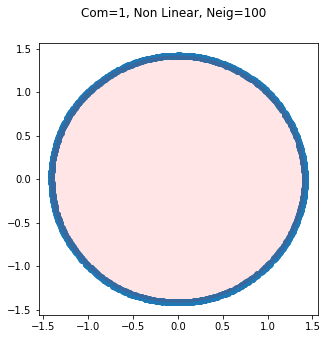

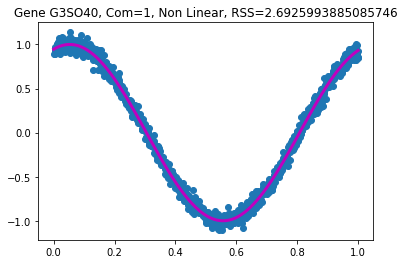

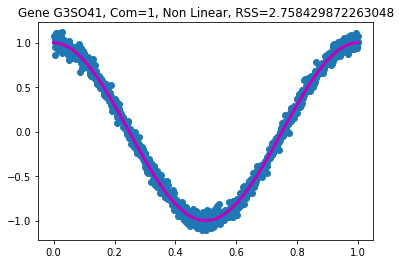

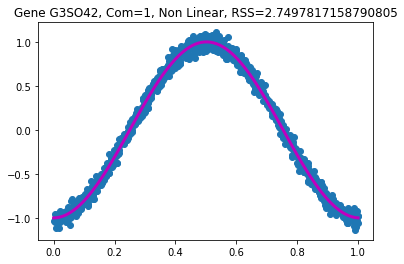

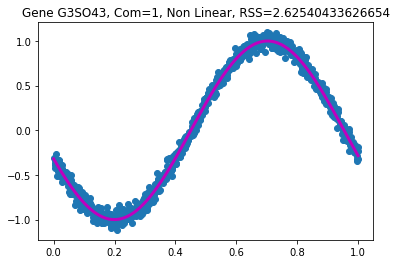

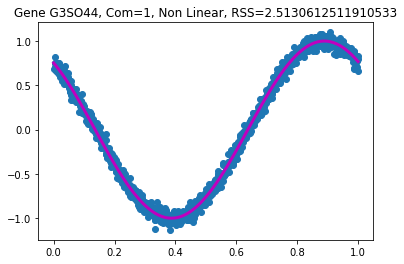

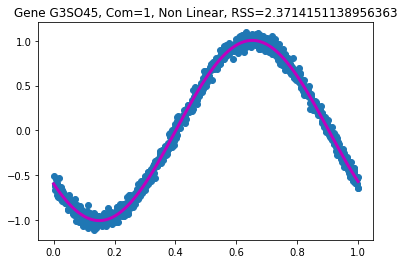

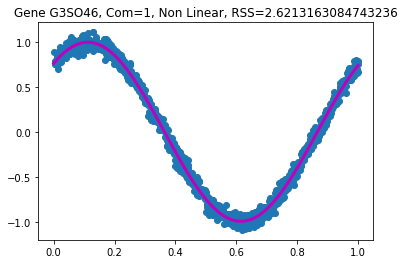

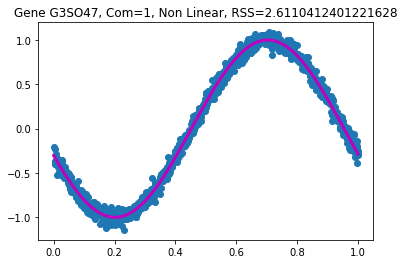

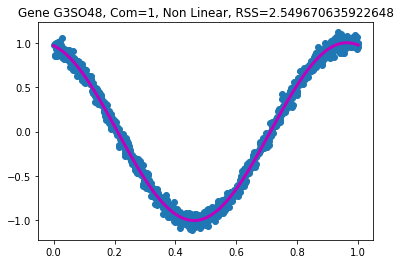

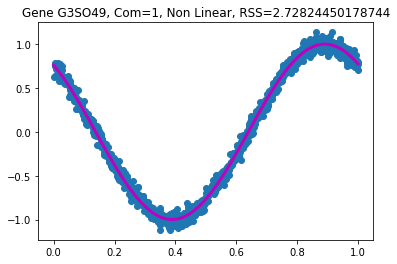

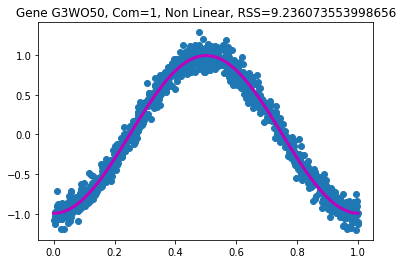

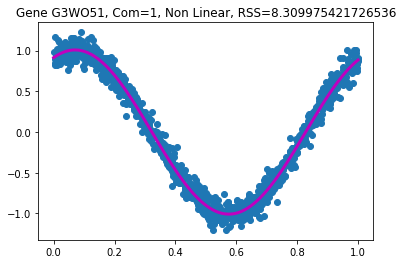

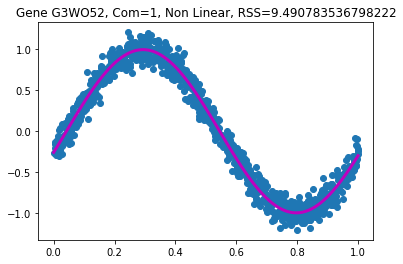

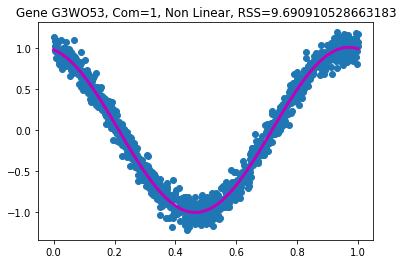

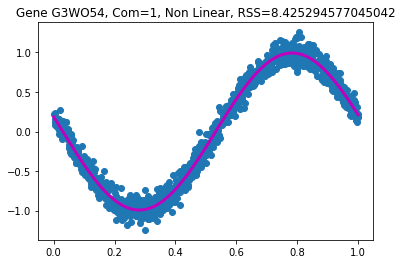

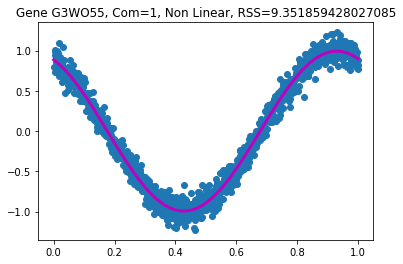

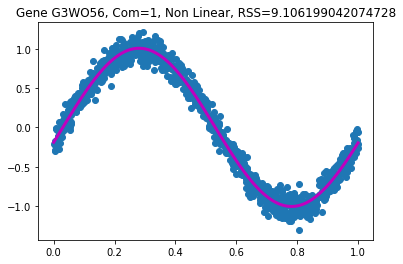

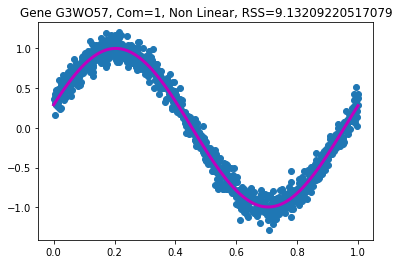

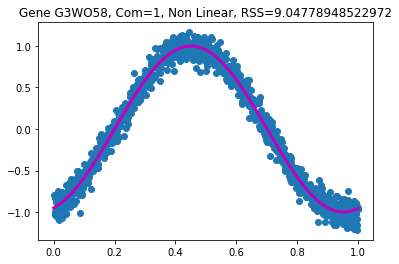

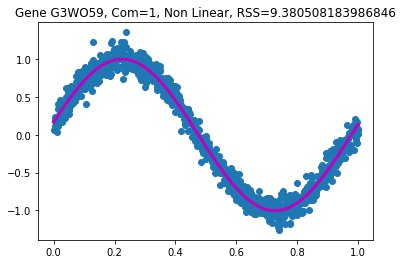

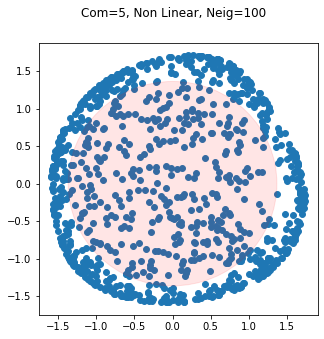

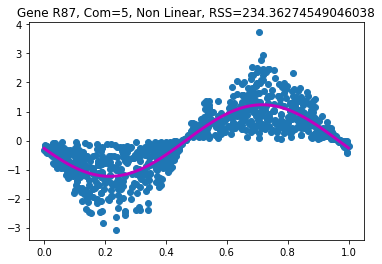

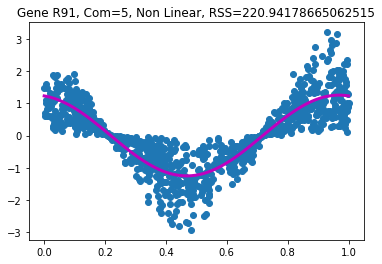

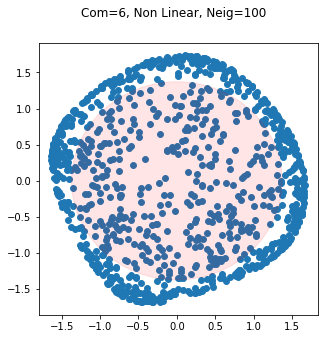

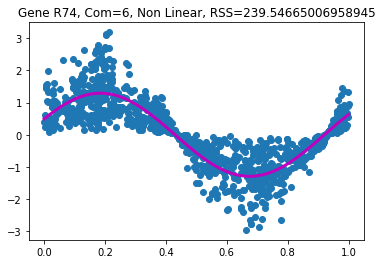

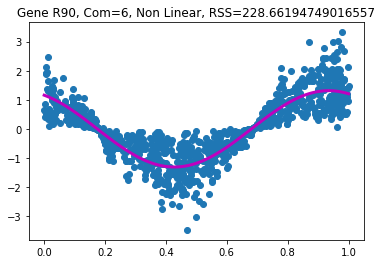

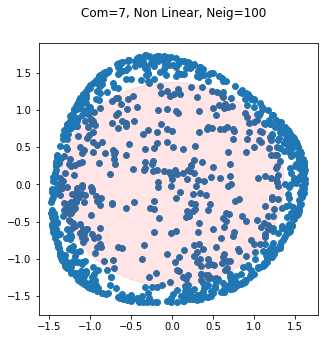

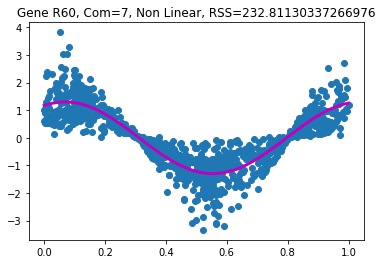

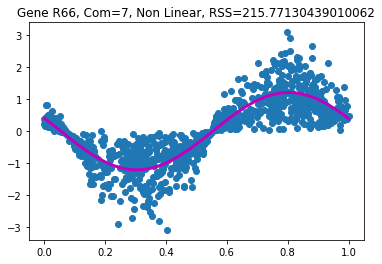

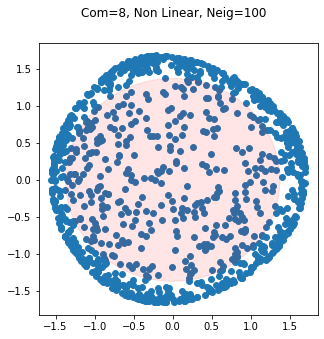

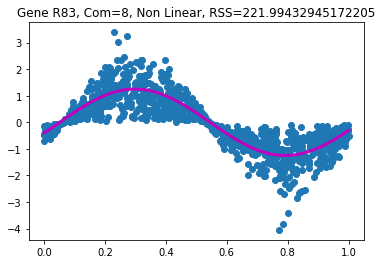

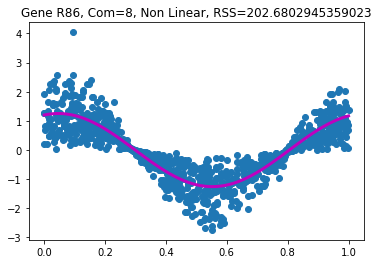

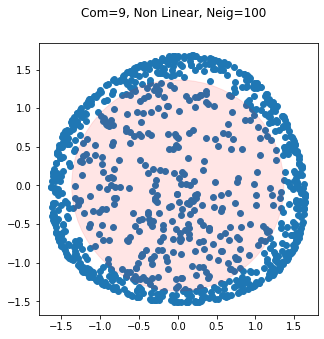

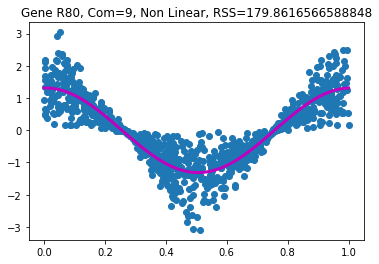

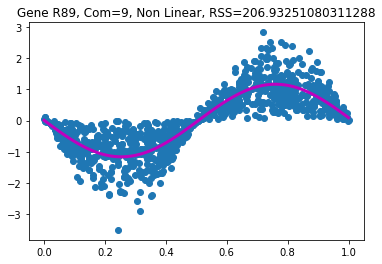

In [10]:
#Start from the linear communities
for commId in NonLinearId:
    print('Community=')
    print(commId)
    #commId=NonLinearId[12]
    Flag="Non Linear"
    comm = commData[commData.CommunityID == commId]
    #select ONLY the genes in the selected community to use laterin the plot
    genelist=comm.index.values
    training_data=data.loc[comm.index]
    nsamp=training_data.shape[1]
    print(training_data.shape)
    n_neighbors=math.ceil(nsamp/10)
    n_neighbors
    pt_spectral, latent_space_2d = estimate_pseudotime_using_spectral_embedding(training_data.T, n_neighbors)
    [fig, ax] = plot_latent_space_notrue(latent_space_2d)
    PseudoTimefile=f'{path_to_fig}NonLinearPseudotime{case}_comm_{commId}.pdf'
    pt = PdfPages(PseudoTimefile)
    fig.suptitle("Com="+str(commId) + ", "+ Flag + ', Neig=' +str(n_neighbors))
    fig
    pt.savefig(fig)
    pt.close()
    #Plot genes
    geneplot=genelist
    idx=np.argsort(pt_spectral)
    figfile=f'{path_to_fig}PlotfilterSin{case}_comm_{commId}.pdf'
    pp = PdfPages(figfile)
    for g in geneplot:

        f=plt.figure()
        gene_series = data.loc[g][idx]
        #fspline = UnivariateSpline(pt_spectral[idx], gene_series, check_finite=True)
        params,params_covariance=optimize.curve_fit(testsin_phase,pt_spectral[idx],gene_series,p0=[2,2,0])
        print(params)
        xtest = np.linspace(np.min(pt_spectral), np.max(pt_spectral), 100)
        #fs = fspline(xtest)
        ts=testsin_phase(xtest,params[0],params[1],params[2])
        residuals=gene_series-testsin_phase(pt_spectral[idx],params[0],params[1],params[2])
        rss=sum(residuals**2)
        #fs = fspline(xtest)
        #plt spline
        plt.plot(xtest, ts, color='m', lw=3);
        #plot data
        plt.scatter(pt_spectral[idx],gene_series)
        plt.title("Gene " + g + ", Com="+str(commId) + ", "+ Flag + ', RSS=' +str(rss) )
        pp.savefig(f)
    pp.close()
    
